# Sequential Convex Programming (SCP) example
22nd October 2025

prepared by Joy Ulusoy

---

## Setup — requirements

Required packages:
- `numpy`
- `matplotlib`
- `cvxpy` (and a backend solver such as `osqp`)

```bash
pip install numpy matplotlib cvxpy osqp
```

(If `OSQP` is unavailable, `cvxpy` will fall back to other solvers, e.g. `SCS`. Please note that results/timings may differ.)


In [17]:
# Setup: imports and parameters
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting (unused import required for some backends)

# Matplotlib inline for Jupyter (if running in notebook)
%matplotlib inline

# Numerical parameters matching the MATLAB script
a1 = -5.1/(4*np.pi**2)
a2 = 5/np.pi
a3 = -6.0
a4 = 10.0
a5 = 1/(8*np.pi)

print('Parameters set: a1..a5 =', a1, a2, a3, a4, a5)

Parameters set: a1..a5 = -0.12918450914398066 1.5915494309189535 -6.0 10.0 0.039788735772973836



---

## Problem statement

We consider the following (nonconvex) optimization problem:
\begin{aligned}
\min_{x_1,x_2} \; & f_1(x_1,x_2)^2 + f_2(x_1,x_2)^2 \\ \quad\text{subject to} & -5 \le x_1 \le 15, \\ & -5 \le x_2 \le 15
\end{aligned}

where
\begin{aligned}
f_1(x_1,x_2) &= x_2 + a_1 x_1^2 + a_2 x_1 + a_3,\\
f_2(x_1,x_2) &= \sqrt{a_4 (\,1 + (1-a_5)\cos(x_1)\,) }.
\end{aligned}


---

## Function definition and visualization

We first define the function $f$ and plot the surface corresponding to $f(x_1,x_2)$ for $-5 \leq x_1 \leq 15$ and $-5 \leq x_2 \leq 15$.


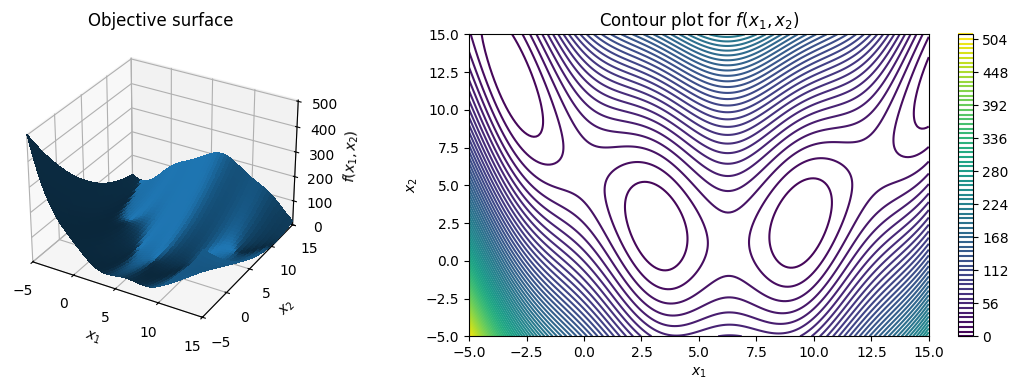

In [18]:
# Define functions and their partial derivatives (numpy implementations)

def f1(x1, x2):
    return x2 + a1*(x1**2) + a2*x1 + a3

def f2(x1, x2):
    # ensure numerical stability for sqrt argument
    arg = 1 + (1 - a5)*np.cos(x1)
    # clip argument to be nonnegative (numerical safety)
    arg = np.maximum(arg, 0.0)
    return np.sqrt(a4)*np.sqrt(arg)

def f(x1, x2):
    return (f1(x1, x2)**2 + f2(x1, x2)**2)

# Plot the original objective surface for reference
x = np.linspace(-5, 15, 200)
y = np.linspace(-5, 15, 200)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X, Y, Z, linewidth=0, antialiased=False)
ax.set_xlim(-5, 15)
ax.set_ylim(-5, 15)
ax.set_zlim(0, np.max(Z))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f(x_1,x_2)$')
ax.set_title('Objective surface')

ax2 = fig.add_subplot(1, 2, 2)
cs = ax2.contour(X, Y, Z, levels=80)
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.set_title('Contour plot for $f(x_1,x_2)$')
plt.colorbar(cs, ax=ax2)
plt.tight_layout()
plt.show()

## Convex approximation of $f$

Since the objective function $f(x_1,x_2)=f_1(x_1,x_2)^2 + f_2(x_1,x_2)^2$ is not convex, we cannot apply CVX directly to solve the non-convex problem:

\begin{aligned}
\min_{x_1,x_2} \; & f_1(x_1,x_2)^2 + f_2(x_1,x_2)^2 \\ \quad\text{subject to} & -5 \le x_1 \le 15, \\ & -5 \le x_2 \le 15
\end{aligned}

Instead, we can apply SCP starting from an initial estimate, e.g. $x_1^k=12$ and $x_2^k=14.5$, with objective value $f^k=f(x_1^k,x_2^k)$:



In [19]:
# Initial point and history
x1k = 12.0
x2k = 14.5
fk = f(x1k, x2k)

# store history of estimates (x1k,x2k) and corresponding objective values fk
x_hist = [[x1k], [x2k]]
f_hist = [fk]

print('Initial point (x1, x2) =', x1k, x2k)
print('Initial objective f =', fk)

Initial point (x1, x2) = 12.0 14.5
Initial objective f = 99.0312259524058


Next, we define $\hat{f}$, a convex approximation of $f$ such that $\hat{f}(x_1,x_2)=f(x_1,x_2)$ around $(x_1^k,x_2^k)$.

Reminder (composition with affine function): if $f(\cdot)$ is convex, then $x \mapsto f(Ax+b)$ is convex.

To define the convex approximation $\hat{f}$ of $f$, we use linear approximations of $f_1$ and $f_2$ given by:

\begin{aligned}
\hat{f}_1(x_1,x_2) = f_1(x^k_1,x^k_2) + \frac{\partial f_1(x_1^k,x_2^k)}{\partial x_1}(x_1-x_1^k) + \frac{\partial f_1(x_1^k,x_2^k)}{\partial x_2}(x_2-x_2^k)
\end{aligned}

(and similarly for $f_2$).

We define the partial derivatives $\frac{\partial f_1}{\partial x_1}$, $\frac{\partial f_1}{\partial x_2}$, $\frac{\partial f_2}{\partial x_1}$ and $\frac{\partial f_2}{\partial x_2}$ and linear/convex function approximations $\hat{f}_1$, $\hat{f}_2$ and $\hat{f}$ below. (For numerical safety we slightly protect divisions by zero where needed.)

In [20]:
# Partial derivatives (analytic)
def f11(x1, x2):
    # df1/dx1
    return 2*a1*x1 + a2

def f12(x1, x2):
    # df1/dx2
    return 1.0

def f1hat(x1, x2):
    # df1/dx1 (derived analytically)
    return f1(x1k, x2k) + f11(x1k, x2k)*(x1 - x1k) + f12(x1k,x2k)*(x2 - x2k)

def f21(x1, x2):
    # df2/dx1 (derived analytically)
    denom = np.sqrt(np.maximum(1 + (1 - a5)*np.cos(x1), 1e-12))
    return np.sqrt(a4) * 0.5 * (-(1 - a5) * np.sin(x1)) / denom

def f22(x1, x2):
    # df2/dx2 = 0 (f2 does not depend on x2)
    return 0.0

def f2hat(x1, x2):
    # df2/dx2 (derived analytically)
    return f2(x1k, x2k) + f21(x1k, x2k)*(x1 - x1k) + f22(x1k,x2k)*(x2 - x2k)

def fhat(x1, x2):
    return f1hat(x1, x2)**2 + f2hat(x1, x2)**2



---

## Sequential Convex Programming (SCP) algorithm

Using CVX, we iteratively solve the convex approximation around $(x_1^k,x_2^k)$ given by

\begin{aligned}
\min_{x_1,x_2} \; & \hat{f}(x_1,x_2) \\ \quad\text{subject to} & -5 \le x_1 \le 15, \\ & -5 \le x_2 \le 15, \\ & ||x-x^k||_{∞} \le \Delta^k
\end{aligned}

We initially consider the approximation $\hat{f}(x_1,x_2) \approx f(x_1,x_2)$ to be accurate for $(x_1,x_2)$ in a neighbourhood of size e.g. $\Delta^k=10$ around $(x_1^k,x_2^k)$ defined by $|| x-x^k ||_{∞} \leq \Delta^k$ or:

\begin{aligned}
|x_1 - x_1^k| \leq \Delta^k \\
|x_2 - x_2^k| \leq \Delta^k
\end{aligned}


Note regarding the definition of the trust region: for $x=(x_1,x_2) \in \mathbb{R}^2$, we have that $|| x ||_{∞} = \max (|x_1|,|x_2|)$, so $|| x ||_{∞} \leq \Delta$ is equivalent to $|x_1|\leq \Delta$ and $|x_2|\leq \Delta$.


In [21]:
# SCP loop implementation using CVXPY (mirrors the MATLAB logic)
# Initial point and history
x1k = 12.0
x2k = 14.5
fk = f(x1k, x2k)

x_hist = [[x1k], [x2k]]
f_hist = [fk]

Deltak = 10.0  # initial trust region radius (as in the MATLAB script)
Ki = np.inf    # progress measure

for k in range(1, 101):  # up to 100 iterations

    # CVXPY decision variables
    x1 = cp.Variable(name='x1')
    x2 = cp.Variable(name='x2')

    # Objective
    objective = cp.Minimize(fhat(x1,x2))

    # Constraints: box and trust-region
    constraints = [
        x1 >= -5, x1 <= 15,
        x2 >= -5, x2 <= 15,
        cp.abs(x1 - x1k) <= Deltak,
        cp.abs(x2 - x2k) <= Deltak
    ]

    prob = cp.Problem(objective, constraints)
    # Solve quietly; prefer OSQP (efficient for QPs)
    try:
        prob.solve(solver=cp.OSQP, verbose=False)
    except Exception as e:
        # fallback to SCS if OSQP not available
        prob.solve(solver=cp.SCS, verbose=False)

    # Extract solution and evaluation metrics
    x1_new = float(x1.value)
    x2_new = float(x2.value)
    cvx_optval = float(prob.value) if prob.value is not None else np.nan

    predicted_impr = fk - cvx_optval
    actual_impr = fk - f(x1_new, x2_new)

    # Acceptance test
    if actual_impr / predicted_impr >= 0.01:
        Ki = abs(actual_impr) / abs(fk) if not np.isclose(fk, 0.0) else 0.0
        x1k = x1_new
        x2k = x2_new
        fk = f(x1k, x2k)
        x_hist[0].append(x1k)
        x_hist[1].append(x2k)
        f_hist.append(fk)
        Deltak = 1.1 * Deltak  # increase trust region if accepted
    else:
        Deltak = 0.5 * Deltak  # decrease trust region if rejected

    # Termination checks
    if Ki <= 1e-3 or Deltak <= 1e-4:
        print(f"Terminated at iteration {k}: Ki={Ki:.2e}, Deltak={Deltak:.2e}")
        break

# Convert history to numpy arrays for plotting convenience
x_hist = np.array(x_hist)
f_hist = np.array(f_hist)

print('Final solution (x1, x2) =', x1k, x2k)
print('Final objective f =', fk)

Terminated at iteration 20: Ki=1.08e-05, Deltak=1.08e-03
Final solution (x1, x2) = 9.424655826268616 2.474896275270753
Final objective f = 0.3978874293468037



---

## Results and interpretation

The figures below show:
- The contour of the original objective and the SCP iteration path (red crosses connected by lines).
- The evolution of the objective value $f(x_1^k,x_2^k)$ across accepted iterates.


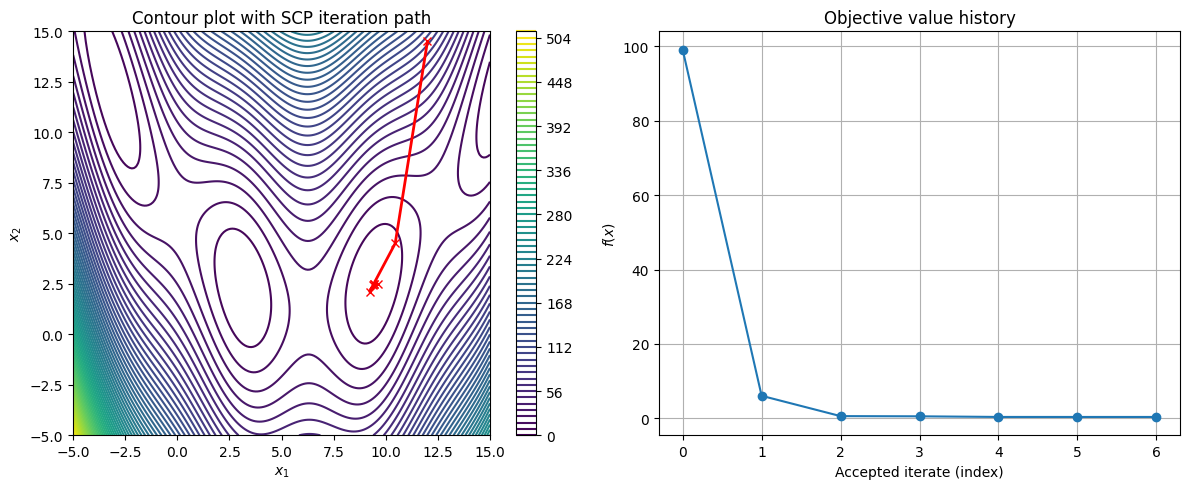

In [22]:
# Plot contour with iteration path and objective history
fig, ax = plt.subplots(1, 2, figsize=(12,5))

# Contour and path
cs = ax[0].contour(X, Y, Z, levels=80)
ax[0].plot(x_hist[0,:], x_hist[1,:], '-xr', linewidth=2, markersize=6)
ax[0].set_xlabel('$x_1$'); ax[0].set_ylabel('$x_2$')
ax[0].set_title('Contour plot with SCP iteration path')
plt.colorbar(cs, ax=ax[0])

# Objective history
ax[1].plot(np.arange(len(f_hist)), f_hist, '-o')
ax[1].set_xlabel('Accepted iterate (index)'); ax[1].set_ylabel('$f(x)$')
ax[1].set_title('Objective value history')
ax[1].grid(True)

plt.tight_layout()
plt.show()


---

## Discussion

1. Try different trust-region radii $\Delta_k$. How does the trust region size affect exploration vs exploitation?
2. Try different initial points (e.g., (-4,0), (0,0), (10,10)). How sensitive is the final solution to initialization?
3. Modify the acceptance threshold (0.01) to 0.1 and re-run. How does the algorithm behave? Does it accept more/less often? Explain why.